## Step 1: Visualizing Stereo Image Pair in Anaglyph Style
We will start by loading the left and right images and visualize them in an anaglyph style (cyan-red overlay). This will help us see the vertical disparity between the two images.

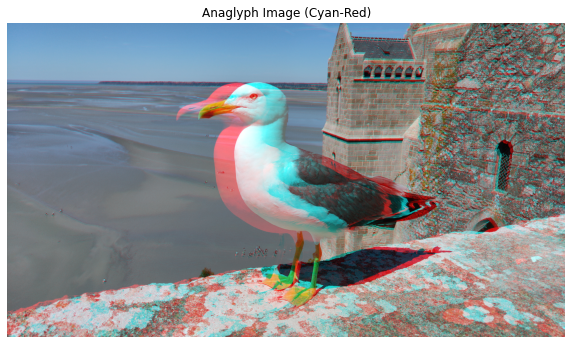

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the stereo image pair in color
left_image_color = cv2.imread('output/albedo_0.jpg')
right_image_color = cv2.imread('output/albedo_1.jpg')
height, width, channels = left_image_color.shape

# Convert color images to grayscale for phase correlation
left_image_gray = cv2.cvtColor(left_image_color, cv2.COLOR_BGR2GRAY)
right_image_gray = cv2.cvtColor(right_image_color, cv2.COLOR_BGR2GRAY)

# Create anaglyph style overlay: left image Cyan, right image Red
anaglyph_image = np.zeros_like(left_image_color)
anaglyph_image[..., 2] = right_image_color[..., 2]  # Red channel
anaglyph_image[..., 1] = left_image_color[..., 1]   # Green channel
anaglyph_image[..., 0] = left_image_color[..., 0]   # Blue channel

# Plot the anaglyph image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(anaglyph_image, cv2.COLOR_BGR2RGB))
plt.title("Anaglyph Image (Cyan-Red)")
plt.axis('off')
plt.show()

## Step 2: Detecting and Correcting Vertical Disparity using Affine Transformation
Now, we will use `cv2.phaseCorrelate` to compute the vertical disparity between the grayscale versions of the left and right images. We will then apply a vertical shift using `cv2.warpAffine` to minimize the disparity and replot the anaglyph overlay for comparison.

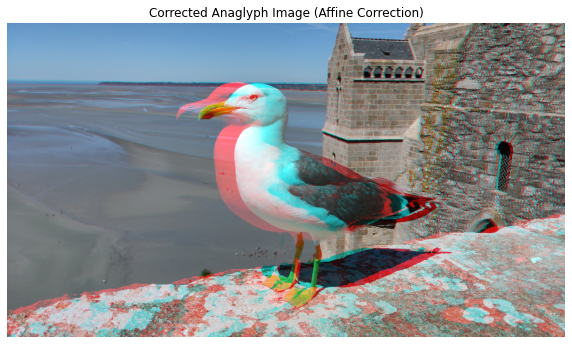

In [32]:
# Use phase correlation on grayscale images to compute vertical disparity
shift, _ = cv2.phaseCorrelate(np.float32(left_image_gray), np.float32(right_image_gray))

# Extract the vertical component of the shift (only care about vertical shift)
vertical_shift = shift[1]

# Compute the affine transformation matrix for vertical translation
translation_matrix_left = np.float32([[1, 0, 0], [0, 1, vertical_shift / 2]])
translation_matrix_right = np.float32([[1, 0, 0], [0, 1, -vertical_shift / 2]])

# Apply vertical translation to both color images
shifted_left_image_color_affine = cv2.warpAffine(left_image_color, translation_matrix_left, (left_image_color.shape[1], left_image_color.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
shifted_right_image_color_affine = cv2.warpAffine(right_image_color, translation_matrix_right, (right_image_color.shape[1], right_image_color.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

# Create a new anaglyph image after affine correction
corrected_anaglyph_image_affine = np.zeros_like(shifted_left_image_color_affine)
corrected_anaglyph_image_affine[..., 2] = shifted_right_image_color_affine[..., 2]  # Red channel
corrected_anaglyph_image_affine[..., 1] = shifted_left_image_color_affine[..., 1]   # Green channel
corrected_anaglyph_image_affine[..., 0] = shifted_left_image_color_affine[..., 0]   # Blue channel

# Plot the corrected anaglyph image (Affine Correction)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(corrected_anaglyph_image_affine, cv2.COLOR_BGR2RGB))
plt.title("Corrected Anaglyph Image (Affine Correction)")
plt.axis('off')
plt.show()

## EXPERIMENT: Estimating and Applying Homography (NO GOOD)
Next, we will estimate the homography transformation matrix between the two grayscale images and apply it to the stereo pair for better rectification.

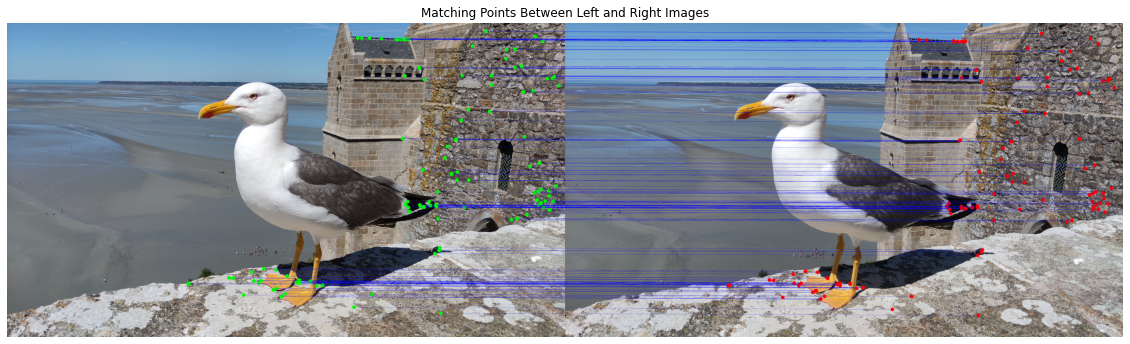

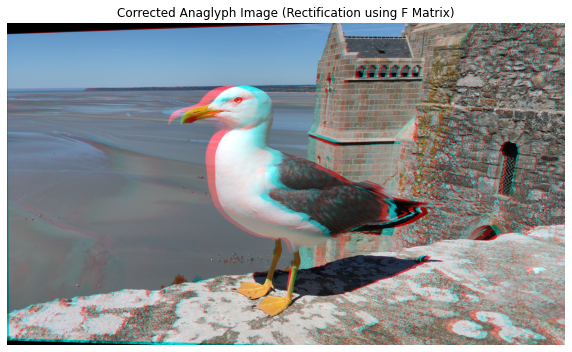

In [34]:
# Detect ORB keypoints and descriptors in both images
orb = cv2.ORB_create()

keypoints_left, descriptors_left = orb.detectAndCompute(left_image_gray, None)
keypoints_right, descriptors_right = orb.detectAndCompute(right_image_gray, None)

# Match keypoints using FLANN matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors_left, descriptors_right)

# Sort matches based on distance (quality of match)
matches = sorted(matches, key=lambda x: x.distance)

# Extract matching points
points_left = np.float32([keypoints_left[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
points_right = np.float32([keypoints_right[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Set the maximum allowable vertical disparity (3% of the image height)
max_vertical_disparity = 0.03 * left_image_color.shape[0]

# Filter out points where the vertical disparity is too large
filtered_points_left = []
filtered_points_right = []

for i in range(len(points_left)):
    # Compute the vertical disparity
    vertical_disparity = abs(points_left[i][0][1] - points_right[i][0][1])
    
    # Keep only points where the vertical disparity is within the threshold
    if vertical_disparity <= max_vertical_disparity:
        filtered_points_left.append(points_left[i])
        filtered_points_right.append(points_right[i])

# Convert the filtered points to numpy arrays
points_left = np.array(filtered_points_left)
points_right = np.array(filtered_points_right)

# Create an image that places the left and right images side by side
left_right_combined = np.hstack((left_image_color, right_image_color))

# Draw matching points and connecting lines
for i in range(len(points_left)):
    # Get the coordinates for left and right points
    pt_left = (int(points_left[i][0][0]), int(points_left[i][0][1]))
    pt_right = (int(points_right[i][0][0] + width), int(points_right[i][0][1]))  # Shift right points by image width

    # Draw circles at the matching points
    cv2.circle(left_right_combined, pt_left, 5, (0, 255, 0), 20)  # Green circle for left image points
    cv2.circle(left_right_combined, pt_right, 5, (0, 0, 255), 20) # Red circle for right image points

    # Draw lines connecting matching points
    cv2.line(left_right_combined, pt_left, pt_right, (255, 0, 0), 1)  # Blue line connecting the points

# Plot the combined image with matching points
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(left_right_combined, cv2.COLOR_BGR2RGB))
plt.title("Matching Points Between Left and Right Images")
plt.axis('off')
plt.show()

# Find the Fundamental Matrix
F, mask = cv2.findFundamentalMat(points_left, points_right, cv2.FM_RANSAC)

# Step 2: Rectify the images using stereoRectifyUncalibrated
_, H1, H2 = cv2.stereoRectifyUncalibrated(points_left, points_right, F, (width, height))

# Step 3: Warp both images to align them
rectified_left_image_color = cv2.warpPerspective(left_image_color, H1, (width, height))
rectified_right_image_color = cv2.warpPerspective(right_image_color, H2, (width, height))

# Step 4: Find the common overlapping area
# Create masks for both rectified images (white where image content is valid, black elsewhere)
mask_left = cv2.warpPerspective(np.ones_like(left_image_gray), H1, (width, height))
mask_right = cv2.warpPerspective(np.ones_like(right_image_gray), H2, (width, height))

# Step 5: Compute the common area (intersection of both masks)
common_region_mask = cv2.bitwise_and(mask_left, mask_right)

# Find bounding box of the common area
x, y, w, h = cv2.boundingRect(common_region_mask)

# Step 6: Crop both images to the common region
cropped_left_image_color = rectified_left_image_color[y:y+h, x:x+w]
cropped_right_image_color = rectified_right_image_color[y:y+h, x:x+w]


# Create a new anaglyph image after rectification
corrected_anaglyph_image_rectified = np.zeros_like(cropped_left_image_color)
corrected_anaglyph_image_rectified[..., 0] = cropped_left_image_color[..., 0]   # Blue channel (from left image)
corrected_anaglyph_image_rectified[..., 1] = cropped_left_image_color[..., 1]   # Green channel (from left image)
corrected_anaglyph_image_rectified[..., 2] = cropped_right_image_color[..., 2]  # Red channel (from right image)

# Plot the corrected anaglyph image (Rectification using F matrix)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(corrected_anaglyph_image_rectified, cv2.COLOR_BGR2RGB))  # Convert to RGB for correct display in matplotlib
plt.title("Corrected Anaglyph Image (Rectification using F Matrix)")
plt.axis('off')
plt.show()

## Saving the Rectified Images (Stereo Rectification)
We will now save the rectified images (based on extrinsic parameters) into the "output" folder.

In [ ]:
# Save rectified images
cv2.imwrite('output/albedo_0_Rect.jpg', rectified_left_image_color)
cv2.imwrite('output/albedo_1_Rect.jpg', rectified_right_image_color)